In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from alive_progress import alive_bar
import time
import os

# Load the data
train_data = pd.read_parquet("data/train_data.parquet")
test_data = pd.read_parquet("data/test_data.parquet")
# test_data = pd.read_csv("matching/matched/output_orig_01_full.csv")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()

In [90]:
test_data.isna().sum().sum()

376504

In [91]:
test_call_cols = [col for col in test_data.columns if col.startswith("call_")]
test_put_cols = [col for col in test_data.columns if col.startswith("put_")]

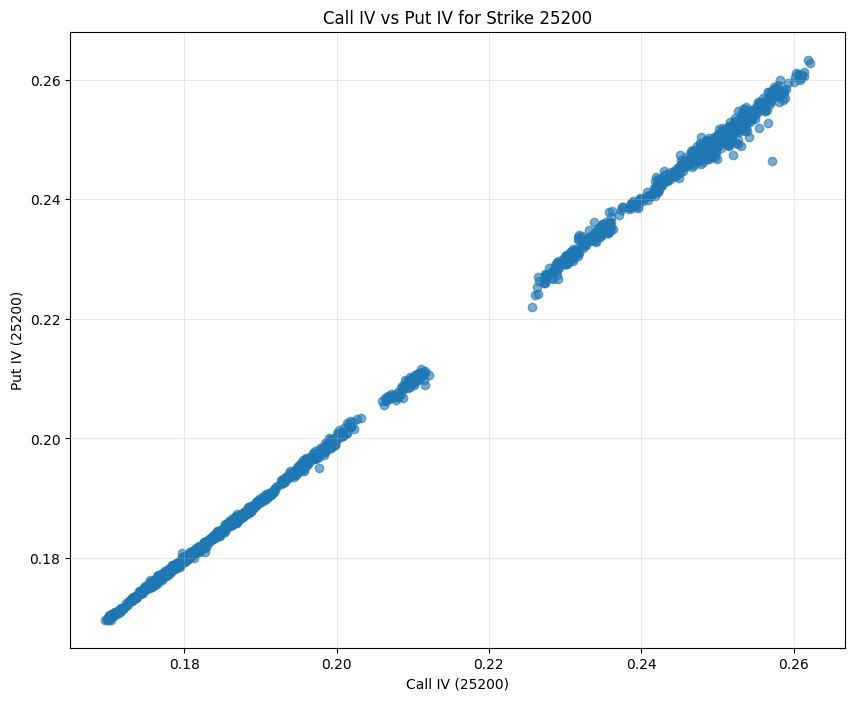

In [92]:
strike = 25200
call_col = f"call_iv_{strike}"
put_col = f"put_iv_{strike}"

# Create scatter plot of call IV vs put IV for the specified strike
plt.figure(figsize=(10, 8))
plt.scatter(test_data[call_col], test_data[put_col], alpha=0.6)
plt.xlabel(f'Call IV ({strike})')
plt.ylabel(f'Put IV ({strike})')
plt.title(f'Call IV vs Put IV for Strike {strike}')
plt.grid(True, alpha=0.3)
plt.show()

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

# Get all strikes that are common between call and put columns
call_strikes = [col.split('_')[-1] for col in test_call_cols]
put_strikes = [col.split('_')[-1] for col in test_put_cols]
common_strikes = sorted(set(call_strikes) & set(put_strikes))

# Dictionary to store models and results
models = {}
results = []

print(f"Training linear regression models for {len(common_strikes)} strikes...")

with alive_bar(len(common_strikes)) as bar:
  for strike in common_strikes:
    call_col = f"call_iv_{strike}"
    put_col = f"put_iv_{strike}"
    
    # Get data where both call and put IV are not null
    mask = test_data[call_col].notna() & test_data[put_col].notna()
    X = test_data.loc[mask, call_col].values.reshape(-1, 1)
    y = test_data.loc[mask, put_col].values
    
    if len(X) > 0:
      # Train linear regression
      model = LinearRegression()
      model.fit(X, y)
      
      # Make predictions and calculate R²
      y_pred = model.predict(X)
      r2 = r2_score(y, y_pred)
      
      # Store model and results
      models[strike] = model
      results.append({
        'strike': int(strike),
        'coefficient': model.coef_[0],
        'intercept': model.intercept_,
        'r2_score': r2,
        'n_samples': len(X)
      })
    
    bar()

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('strike')

print(f"\nLinear Regression Results (Call IV → Put IV):")
print(results_df.to_string(index=False))

Training linear regression models for 16 strikes...
|████████████████████████████████████████| 16/16 [100%] in 0.0s (918.76/s) 

Linear Regression Results (Call IV → Put IV):
 strike  coefficient  intercept  r2_score  n_samples
  24000     1.044538  -0.004085  0.967231       1901
  24100     0.985672   0.006839  0.934457       1911
  24200     0.982363   0.006486  0.981079       1990
  24300     0.974863   0.007157  0.993819       2008
  24400     0.997627   0.001643  0.997779       1914
  24500     1.004207  -0.000208  0.999044       1903
  24600     1.004381  -0.000842  0.999670       1888
  24700     1.002242  -0.000581  0.999698       1906
  24800     0.998854   0.000075  0.999867       1901
  24900     0.997201   0.000531  0.999862       1990
  25000     0.996006   0.000511  0.999685       1926
  25100     1.005372  -0.001086  0.999794       1858
  25200     0.999590  -0.000115  0.999533       1941
  25300     0.987601   0.001942  0.998615       1907
  25400     0.981849   0.00291

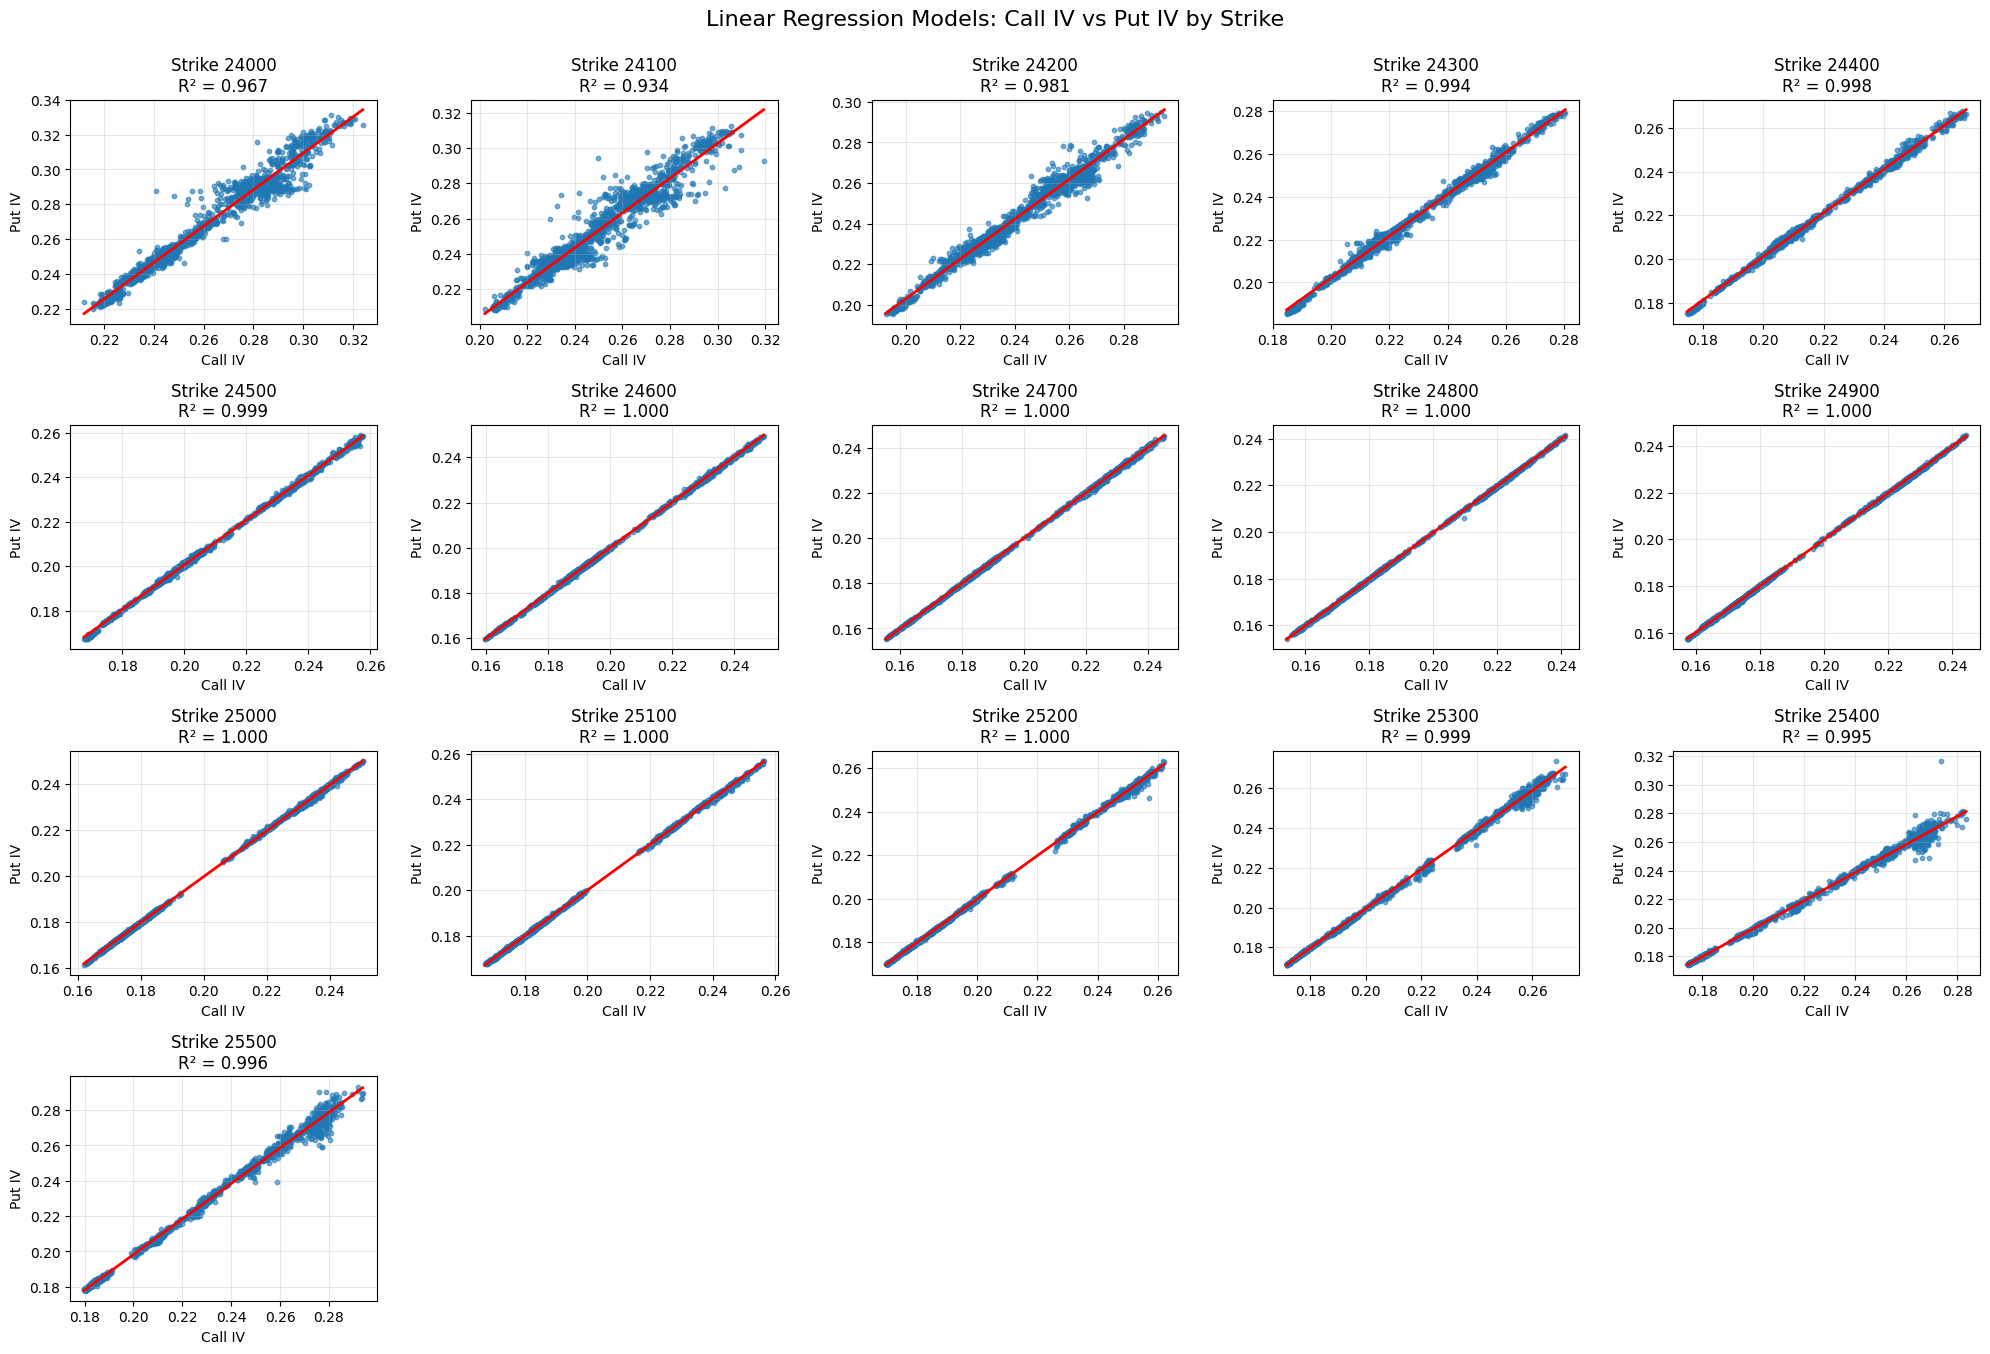

In [94]:
# Create subplots to visualize the linear regression models
fig, axes = plt.subplots(5, 5, figsize=(20, 16))
axes = axes.flatten()

# Select a subset of strikes to visualize (first 25)
strikes_to_plot = common_strikes[:25]

for i, strike in enumerate(strikes_to_plot):
  call_col = f"call_iv_{strike}"
  put_col = f"put_iv_{strike}"
  
  # Get data where both call and put IV are not null
  mask = test_data[call_col].notna() & test_data[put_col].notna()
  X = test_data.loc[mask, call_col].values
  y = test_data.loc[mask, put_col].values
  
  # Get the model for this strike
  model = models[strike]
  
  # Create prediction line
  x_line = np.linspace(X.min(), X.max(), 100)
  y_line = model.predict(x_line.reshape(-1, 1))
  
  # Plot scatter and regression line
  axes[i].scatter(X, y, alpha=0.6, s=10)
  axes[i].plot(x_line, y_line, 'r-', linewidth=2)
  axes[i].set_xlabel(f'Call IV')
  axes[i].set_ylabel(f'Put IV')
  axes[i].set_title(f'Strike {strike}\nR² = {results_df[results_df.strike == int(strike)]["r2_score"].iloc[0]:.3f}')
  axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(strikes_to_plot), len(axes)):
  fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Linear Regression Models: Call IV vs Put IV by Strike', fontsize=16, y=1.02)
plt.show()

In [95]:
test_data.isna().sum().sum()

376504

In [96]:
# Fill missing IVs using linear regression models for strikes 24600 to 25100
fill_strikes = [str(strike) for strike in range(24600, 25200, 100)]  # 24600 to 25100 inclusive

print(f"Filling missing IVs for strikes: {fill_strikes}")

for strike in fill_strikes:
  if strike in models:
    call_col = f"call_iv_{strike}"
    put_col = f"put_iv_{strike}"
    model = models[strike]
    
    # Find rows where call IV is present but put IV is missing
    call_present_put_missing = test_data[call_col].notna() & test_data[put_col].isna()
    if call_present_put_missing.sum() > 0:
      # Predict put IV from call IV
      call_values = test_data.loc[call_present_put_missing, call_col].values.reshape(-1, 1)
      predicted_put = model.predict(call_values)
      test_data.loc[call_present_put_missing, put_col] = predicted_put
      print(f"Strike {strike}: Filled {call_present_put_missing.sum()} missing put IVs using call IV")
    
    # Find rows where put IV is present but call IV is missing
    # For this, we need the inverse relationship (put -> call)
    put_present_call_missing = test_data[put_col].notna() & test_data[call_col].isna()
    if put_present_call_missing.sum() > 0:
      # Use inverse relationship: call = (put - intercept) / coefficient
      put_values = test_data.loc[put_present_call_missing, put_col].values
      predicted_call = (put_values - model.intercept_) / model.coef_[0]
      test_data.loc[put_present_call_missing, call_col] = predicted_call
      print(f"Strike {strike}: Filled {put_present_call_missing.sum()} missing call IVs using put IV")

print("\nFilling complete!")

Filling missing IVs for strikes: ['24600', '24700', '24800', '24900', '25000', '25100']
Strike 24600: Filled 2899 missing put IVs using call IV
Strike 24600: Filled 2930 missing call IVs using put IV
Strike 24700: Filled 2944 missing put IVs using call IV
Strike 24700: Filled 2870 missing call IVs using put IV
Strike 24800: Filled 2918 missing put IVs using call IV
Strike 24800: Filled 2884 missing call IVs using put IV
Strike 24900: Filled 2910 missing put IVs using call IV
Strike 24900: Filled 2857 missing call IVs using put IV
Strike 25000: Filled 2892 missing put IVs using call IV
Strike 25000: Filled 2863 missing call IVs using put IV
Strike 25100: Filled 2968 missing put IVs using call IV
Strike 25100: Filled 2870 missing call IVs using put IV

Filling complete!


In [97]:
test_data.isna().sum().sum()

341699

In [98]:
test_data.to_csv("data/some_put_matched.csv", index=False)
test_data

,timestamp,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,24735.9,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,...,0.006587,0.002826,-1.737617e+05,-0.009541,-0.017831,0.000264,2.032521e+06,1.000000e-06,-0.077238,-5.362742e+06
1,1,24766.7,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,0.228278,...,0.005777,0.004588,-3.195086e+05,-0.024106,-0.004696,-0.000158,-4.529075e+06,-1.619022e+06,-0.956928,4.624907e+06
2,2,24896.9,NaN,0.251731,NaN,NaN,0.214869,0.204580,0.194604,0.188211,...,0.000829,-0.034944,1.027525e+06,0.028201,0.032234,0.007687,2.663908e+06,0.000000e+00,-0.116264,-2.669766e+06
3,3,24898.1,0.241888,NaN,0.220505,NaN,0.198602,0.186190,NaN,0.166601,...,-0.009323,-0.022969,-4.720074e+06,-0.001513,0.008704,-0.000206,-7.672936e+06,-1.903406e+06,-2.249208,-1.858254e+07
4,4,24906.5,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,...,-0.018674,-0.007588,-4.051681e+05,-0.136267,0.002425,-0.002200,1.334469e+06,2.548789e+05,1.999104,3.024212e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,24992.1,NaN,0.233427,NaN,NaN,NaN,NaN,NaN,0.186856,...,-0.010750,0.006911,-1.497117e+05,-0.059785,-0.014518,-0.006756,-7.822864e+06,2.149933e+05,-2.069687,-6.738094e+06
12061,12061,25020.3,NaN,0.236380,0.226972,NaN,NaN,0.200906,0.193655,NaN,...,-0.000224,0.024468,-1.176289e+06,-0.016344,-0.034368,0.001133,-2.392407e+06,-1.176289e+06,-2.023157,6.031379e+03
12062,12062,24897.2,0.256475,0.243817,0.234267,0.221270,NaN,NaN,0.192305,0.185088,...,-0.009009,0.006057,1.920387e+06,-0.016521,-0.013230,-0.009278,2.287786e+06,0.000000e+00,1.751653,-3.621450e+06
12063,12063,25035.6,NaN,0.239825,NaN,NaN,NaN,NaN,NaN,0.190833,...,0.001625,0.063421,6.357844e+05,0.077753,0.068983,0.000112,8.723009e+06,2.352188e+05,1.502687,-1.177899e+06


In [99]:
test_cols = test_call_cols + test_put_cols 



test_data[test_cols].to_csv("data/some_put_matched_r.csv", index=False, header=False)

In [100]:
test_cols.__len__()

52